In [2]:
from IPython.display import Image
from IPython.core.display import HTML 
import os
import pandas as pd
import nltk
from collections import Counter

# Stage 1: Dataset Preparation

1. Downloading naama's corpus from here: https://www.cs.bgu.ac.il/~elhadad/nlpproj/naama/
2. **Transorming the tagged data to be sequence of words** in order to activate LDA (Adler's code)
Using function corpus_to_text(): 

    ```python
    def corpus_to_text():
        data_path = "resources" + os.sep + "tagged_corpus_naama.txt"
        with open(data_path, 'r', encoding='utf8') as f:
            all_text = []
            lines = f.readlines()
            for line in lines:
                all_text.append(line.split(" ")[0])

        all_text_str = " ".join(all_text)
        data_str_path = "resources" + os.sep + "corpus_text_naama.txt"
        with open(data_str_path, 'w', encoding='utf8') as f:
            f.write(all_text_str)
    ```

3. Using **hebtokenizer.py** in order to tokenize the sequence of words, in order for making it suitable input for Adler's LDA Code. 
> python hebtokenizer.py "corpus_text_naama.txt" "corpus_text_naama_tokenized.txt"

4. Download **LDA code** from here: https://www.cs.bgu.ac.il/~elhadad/nlpproj/LDAforHebrew.html
5. Editing **lemlda\tagger\tag.bat** code in order to be able to receive the data as conll:

    > REM Use -bWST for white space tagger instead of the broken Mila tagger.
     REM This assumes the text has been tokenized before with hebtokenizer.py
     java -Xmx1200m -cp trove- 2.0.2.jar;XMLAnalyzer.jar;morphAnalyzer.jar;opennlp.jar;gnu.jar;chunker.jar;splitsvm.jar;duck1.jar;tagger.jar > vohmm.application.BasicTagger %~dp0 %~f1 %~f2 -bWST -conll

        The change - is to add the '-conll' tag in the end of the usage line. 

6. Now we can **use Adler's LDA Code!** 

    cd lemlda\tagger and execute:
> tag "corpus_text_naama_tokenized.txt" "corpus_text_naama_processed.txt"

7. Now we have 2 main files: 

    a) tagged_corpus_naama - the original tagged corpus (bio tag for each name)

> --  DOCSTART-- O  
    אחד O  
    מכל O  
    שני O  
    ישראלים I_MISC__AFF  
    אוכלים O  
    קורנפלקס O  
    . O  
    
    b) corpos_text_naama_processed - features for each word without the bio tag
    
>   99 DOCSTART DOCSTART DOCSTART foreign unspecified unspecified unspecified unspecified unspecified  
    100 - - - punctuation unspecified unspecified unspecified unspecified unspecified  
    101 - - - punctuation unspecified unspecified unspecified unspecified unspecified  
    102 אחד CARD1 אחד numeral masculine singular absolute unspecified unspecified  
    103 מ מ מכל preposition unspecified unspecified unspecified unspecified unspecified 0  
    103 כל כול מכל quantifier unspecified unspecified construct unspecified unspecified  
    104 שני שני שני noun masculine singular absolute unspecified unspecified  
    105 ישראלים ישראלי ישראלים noun masculine plural absolute unspecified unspecified  
    106 אוכלים אוכל אוכלים noun masculine plural absolute unspecified unspecified  
    107 קורנפלקס קורנפלקס קורנפלקס properName unspecified unspecified unspecified unspecified unspecified  
    108 . . . punctuation unspecified unspecified unspecified unspecified unspecified 

   We want to **merge** those files. 
   
   In order to do it, we'll use **CorpusTagMerger.py** file, and receive merged output:    

> אחד O 102 CARD1 אחד numeral masculine singular absolute unspecified unspecified no_pref no_suffix
כל O 103 כול מכל quantifier unspecified unspecified construct unspecified unspecified מ no_suffix
שני O 104 שני שני noun masculine singular absolute unspecified unspecified no_pref no_suffix
ישראלים I_MISC__AFF 105 ישראלי ישראלים noun masculine plural absolute unspecified unspecified no_pref no_suffix
אוכלים O 106 אוכל אוכלים noun masculine plural absolute unspecified unspecified no_pref no_suffix
קורנפלקס O 107 קורנפלקס קורנפלקס properName unspecified unspecified unspecified unspecified unspecified no_pref no_suffix
. O 108 . . punctuation unspecified unspecified unspecified unspecified unspecified no_pref no_suffix

Notice we did it by taking the prefix or the suffix (if they were relevant) as features.  
For example for the word 'מכל' we have prefix of 'מ'. (Prefix which indicates "from" in hebrew) 
For the word 'קורנפלקס' we don't have a prefix nor suffix.  
For the word 'כשהלכתי' we have prefix of 'כש' and a suffix of 'תי'. (Prefix which indicates "While" in hebrew)  

For convenience, we'll make pandas dataframe of this output in order to get a nice structure.

This dataframe we'll be saved at **resources\dataset.csv**

Let's observe part of it:

In [3]:
dataset = pd.read_csv('resources' + os.sep + 'dataset.csv')
dataset.head(5)

,Bio,Gender,Lemma,Number,Person,Pos,Prefix,Status,Suffix,Tense,Token,TokenOrder,Word
0,O,unspecified,DOCSTART,unspecified,unspecified,foreign,no_pref,unspecified,no_suffix,unspecified,DOCSTART,99,DOCSTART
1,O,masculine,CARD1,singular,unspecified,numeral,no_pref,absolute,no_suffix,unspecified,אחד,102,אחד
2,O,unspecified,כול,unspecified,unspecified,quantifier,מ,construct,no_suffix,unspecified,מכל,103,כל
3,O,masculine,שני,singular,unspecified,noun,no_pref,absolute,no_suffix,unspecified,שני,104,שני
4,I_MISC__AFF,masculine,ישראלי,plural,unspecified,noun,no_pref,absolute,no_suffix,unspecified,ישראלים,105,ישראלים


Now we want to change the **BIO** tags to **BILUO** which means Begin, In, Last, Unit, O. 

We'll use the following code:
```python
BASIC_BIO_TAGS = {'MISC', 'PERCENT', 'LOC', 'TIME', 'ORG', 'PERS', 'DATE', 'MONEY'}

def split_tag_to_basic(tag):
    if len(tag.split("_")) > 1:
        return tag.split("_")[1].rstrip("\n")
    else:
        return tag
    
def get_tags_df(i, lines):
    prev_line = lines.iloc[i - 1]
    curr_line = lines.iloc[i]
    next_line = lines.iloc[i + 1]

    prev_tag = prev_line['Bio']
    curr_tag = curr_line['Bio']
    next_tag = next_line['Bio']

    return prev_tag, curr_tag, next_tag

dataset = pd.read_csv("resources" + os.sep + "dataset.csv")
for i in range(0, len(dataset)-1):
    prev_tag, curr_tag, next_tag = get_tags_df(i, dataset)
    new_tag = curr_tag
    if split_tag_to_basic(curr_tag) in BASIC_BIO_TAGS:
        if split_tag_to_basic(prev_tag) != split_tag_to_basic(curr_tag) and split_tag_to_basic(
                curr_tag) != split_tag_to_basic(next_tag):
            new_tag = 'U-' + split_tag_to_basic(curr_tag)
        else:
            if split_tag_to_basic(prev_tag) == split_tag_to_basic(curr_tag):
                if split_tag_to_basic(curr_tag) != split_tag_to_basic(next_tag):
                    new_tag = 'L-' + split_tag_to_basic(curr_tag)
                else:  # split_tag_to_basic(curr_tag) == split_tag_to_basic(next_tag)
                    new_tag = 'I-' + split_tag_to_basic(curr_tag)
            else:  # split_tag_to_basic(prev_tag) != split_tag_to_basic(curr_tag) BUT split_tag_to_basic(curr_tag) != split_tag_to_basic(next_tag)
                new_tag = 'B-' + split_tag_to_basic(curr_tag)
    dataset.at[i, 'BILUO'] = new_tag
dataset.drop(columns=['Bio'])
dataset.to_csv("dataset_biluo.csv", index=False)
```

Which we'll produce the final file **dataset_biluo.csv** 

Now we'll see example how to **bio_to_biluo** function works: 


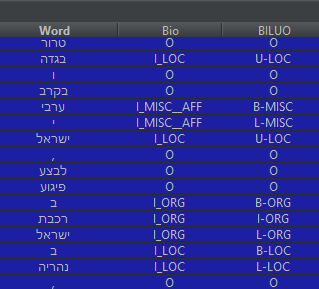

In [4]:
pic_path = 'resources' + os.sep + 'PicForNotebook.PNG'
Image(filename = pic_path)

As we can see, it substitutes the I-X to be one of the following:
* B-X (If it's in the beginning) 
* I-X (If it's in the middle)
* L-X (If it's last)
* U-X (if it's one init)

In [5]:
biluo_dataset = pd.read_csv('resources' + os.sep + 'dataset_biluo.csv')
biluo_dataset[62886: 62894]

,Bio,Gender,Lemma,Number,Person,Pos,Prefix,Status,Suffix,Tense,Token,TokenOrder,Word,BILUO
62886,I_MONEY,unspecified,###NUMBER###,unspecified,unspecified,numeral,no_pref,unspecified,no_suffix,unspecified,###NUMBER###,63866,###NUMBER###,B-MONEY
62887,I_MONEY,masculine,ORD-CARD1000000,plural,unspecified,numeral,no_pref,absolute,no_suffix,unspecified,מיליון,63867,מיליון,I-MONEY
62888,I_MONEY,masculine,דולר,singular,unspecified,noun,no_pref,absolute,no_suffix,unspecified,דולר,63868,דולר,L-MONEY
62889,O,feminine,שינה,singular,unspecified,noun,ב,construct,no_suffix,unspecified,בשנת,63869,שנת,O
62890,I_DATE,unspecified,###NUMBER###,unspecified,unspecified,numeral,no_pref,unspecified,no_suffix,unspecified,###NUMBER###,63870,###NUMBER###,U-DATE
62891,O,unspecified,.,unspecified,unspecified,punctuation,no_pref,unspecified,no_suffix,unspecified,.,63871,.,O
62892,I_ORG,unspecified,ריטליקס,unspecified,unspecified,properName,no_pref,unspecified,no_suffix,unspecified,ריטליקס,63872,ריטליקס,U-ORG
62893,O,feminine,פיתח,singular,any,participle,no_pref,absolute,no_suffix,unspecified,מפתחת,63873,מפתחת,O


# STATISTICS 📊 📈 📉

* Report statistics on the dataset (number of tokens, number of chunks of each type, tags of each type, vocabulary size, number of sentences, average length of sentences) 

In [6]:
with open('resources' + os.sep + 'old_files' + os.sep + 'tagged_corpus_naama.txt', 'r', encoding='utf-8') as f:
    tagged_corpus = f.readlines()

with open('resources' + os.sep + 'old_files' + os.sep + 'corpus_text_naama.txt', 'r', encoding='utf-8') as f:
    corpus_lines = f.readlines()

In [7]:
corpus_txt = " ".join(corpus_lines)

In [8]:
corpus_txt

'--DOCSTART-- \n  נראה שאביטל אברג\'יל ( לשעבר אוז ) , אוהבת לא רק לשחק אצל דן תורג\'מן ( בסרט " משהו מתוק " ) , אלא גם איתו . \n  תורג\'מן , שכבר מזמן לא גר תחת קורת גג אחת עם ענת עצמון , הגיע ביום חמישי האחרון לבית קפה-מסעדה " אוליב " בת"א , שם חיכתה לו אביטל לבדה . \n  הפגישה המרגשת בין השניים כללה חיבוקים , נשיקות ושאר ירקות , עד שלפתע נצפו השניים מתזמזים קלות על הספה . \n  בשלב מאוחר יותר של הערב אפילו השתעשעה אביטל כשבליינית במקום שאלה אותי אם היא ודן זוג . \n  אברג\'יל , נבוכה קלות , פצחה בצחוק היסטרי ואמרה לדן : " שמעת , חושבים שאנחנו זוג " , למען מי שעוד לא שמע . \n  לכל הספקנים שביניכם , בטח תסכימו שעמיתים למקצוע לא מלקקים אחד לשני את הצוואר , וזה אחרי שהצנענו את המתרחש . \n  אביטל , מסמנת עוד וי ברשימת הסלבז ? \n  " אני לא מגיבה על שום דבר שקשור לחיי הפרטים ושיהיה לך יום טוב " . \n  הפרוד לא היה זמין להביע דעתו בעניין . \n  --DOCSTART-- \n  אחד מכל שני ישראלים אוכלים קורנפלקס . \n  שליש מהם נהנים ממנו בבוקר , 14 אחוז אוכלים אותו בערב , ואילו 3 % אוכלים קורנפלקס בצהריים . \n 

## All of the following statistics are given to the tokenized text printed in the previous cell.

## Number of tokens

In [9]:
number_of_tokens = len(nltk.word_tokenize(corpus_txt))
number_of_tokens

64692

In [10]:
number_of_unique_tokens = len(set(nltk.word_tokenize(corpus_txt)))
number_of_unique_tokens

18601

## Number of tags of each type

In [11]:
all_tags_lst = []
all_words_set = set()

for sentence in tagged_corpus:
    sentence_parts = [w.strip("\n") for w in sentence.split(" ")]
    all_words_set.add(sentence_parts[0])
    if len(sentence_parts) > 1:
        all_tags_lst.append(sentence_parts[1])

c = Counter(all_tags_lst)
c

Counter({'O': 54699,
         'I_PERS': 2109,
         'I_MISC__ENT': 193,
         'I_DATE': 633,
         'I_ORG': 1992,
         'I_LOC': 1572,
         'I_MISC__AFF': 725,
         'I_PERCENT': 257,
         'B_LOC': 95,
         'B_ORG': 26,
         'B_MISC__AFF': 17,
         'I_TIME': 57,
         'I_MISC_EVENT': 114,
         'B_DATE': 6,
         'B_PERS': 43,
         'I_MONEY': 551,
         'B_MISC__ENT': 1,
         'B_TIME': 1})

## Vocabulary size

In [12]:
if "" in all_words_set:
    all_words_set.remove("")

len(all_words_set)

18759

## Number of sentences

In [13]:
all_sentences = corpus_txt.split("\n")
number_of_sentences = len(all_sentences)
number_of_sentences

3484

## Average length of sentence

In [14]:
average_length_of_sentences = sum([len(sentence.split(" ")) for sentence in all_sentences]) / len(all_sentences)
average_length_of_sentences

21.10792192881745

### Tags distribution

In [15]:
biluo_dataset['BILUO'].value_counts()

O            54541
U-LOC          829
U-MISC         735
U-PERS         663
B-PERS         662
L-PERS         662
L-ORG          646
B-ORG          646
U-ORG          455
L-LOC          344
B-LOC          344
I-ORG          267
U-DATE         203
B-MONEY        189
L-MONEY        189
L-DATE         168
B-DATE         168
U-PERCENT      160
I-MONEY        154
I-PERS         151
I-LOC          149
B-MISC         109
L-MISC         109
I-DATE          98
I-MISC          95
L-PERCENT       47
B-PERCENT       47
U-MONEY         19
B-TIME          18
L-TIME          18
I-TIME          12
U-TIME          10
I-PERCENT        3
Name: BILUO, dtype: int64

Let's count how many values starts with U 

In [25]:
tag_values = biluo_dataset['BILUO'].value_counts()

In [35]:
tag_values_starts_with_u = tag_values[[x for x in tag_values.keys() if x.startswith("U")]]
tag_values_starts_with_u

U-LOC        829
U-MISC       735
U-PERS       663
U-ORG        455
U-DATE       203
U-PERCENT    160
U-MONEY       19
U-TIME        10
Name: BILUO, dtype: int64

In [38]:
f"All tags: {tag_values.sum()}, U tags: {tag_values_starts_with_u.sum()}, proportion: {round(tag_values_starts_with_u.sum() / tag_values.sum(), 3)}"

'All tags: 62910, U tags: 3074, proportion: 0.049'

First of all, U tags are isolated, so we expect them to be easier to learn.  
In addition, if the gazzete values will be good, we expect them to help mostly to the U tags.  
On the other hand, their proportion is not so big.  
So we hope for improvement using the U tags compare to not using them, but not a drastic one.

## Now we can go to 'Phase2_ML' and see the Machine Learning Part 😄 